<a href="https://colab.research.google.com/github/xanderdavies/unifying-grok-dd/blob/main/toy_grok_dd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Model of Pattern Learning

Xander Davies, Lauro Langosco, Jesse Hoogland, and David Krueger

Check out the [overleaf](https://www.overleaf.com/project/6415d1fdc6e582a50e60bb77) for an overview.

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import wandb

wandb.login()
%matplotlib inline

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


<!-- We define accuracy $\text{acc}(t)$ at timestep $t$ per:

\begin{align}
\text{acc}(t) &= \text{pred}_1(t) \cup \text{pred}_2(t) \cup \text{pred}_3(t) \\
&= \text{pred}_1(t) + \text{pred}_2(t) + \text{pred}_3(t) - \left(\text{pred}_1(t) \text{pred}_2(t) + \text{pred}_1(t) \text{pred}_3(t) + \text{pred}_2(t) \text{pred}_3(t)\right) + \text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) 
\end{align}

We define pattern usage $u_i(t)$ as the proportion of examples seen by $p_i$ at timestep $t$, which is upperbounded by $\text{pred}_i(t)$:
\begin{align}
u_1(t) &= \text{pred}_1(t) - \text{pred}_1(t) \text{pred}_3(t) + \frac{\text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) - \text{pred}_1(t) \text{pred}_2(t)}{2} \\
u_2(t) &= \text{pred}_2(t) - \text{pred}_2(t) \text{pred}_3(t) + \frac{\text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) - \text{pred}_1(t) \text{pred}_2(t)}{2} \\
u_3(t) &= \text{pred}_3(t)
\end{align}

*Note that $u_1(t) + u_2(t) + u_3(t) \leq 1$, $\forall t \geq 0, \text{pred}_i \leq 1$.*

We then say our model generalizes according to each pattern's generality $g_i$ applied to each usage $u_i(t)$:

\begin{align}
\text{gen}(t) = g_1 u_1(t) + g_2 u_2(t) + g_3 u_3(t)
\end{align} -->

In [32]:
def clamp(x: jnp.ndarray, min=0, max=1):
    """Clamp the input x between min and max values."""
    return jnp.minimum(jnp.maximum(x, min), max)


def smootherstep(x: jnp.ndarray):
    """Compute the smootherstep function for the input x.
    
    See [Smoothstep & Smootherstep](https://en.wikipedia.org/wiki/Smoothstep).  
    """
    x = clamp(x)
    return x ** 3 * (x * (x * 6 - 15) + 10)


def prob(data: jnp.ndarray, budget: jnp.ndarray, costs: jnp.ndarray):
    """Calculate the probability of correct classification through specific behaviors."""
    contributions = (1 - data * smootherstep(budget / costs))
    return 1 - jnp.prod(contributions, axis=1)


def accuracy(data: jnp.ndarray, budget: jnp.ndarray, costs: jnp.ndarray):
    """Compute the average accuracy of the model."""
    return jnp.mean(prob(data, budget, costs))


def loss_item(data: jnp.ndarray, budget: jnp.ndarray, costs: jnp.ndarray):
    """Calculate the per-sample loss."""
    return -jnp.log(prob(data, budget, costs))


def loss(data: jnp.ndarray, budget: jnp.ndarray, costs: jnp.ndarray):
    """Compute the total loss."""
    return jnp.mean(loss_item(data, budget, costs))


class BaseLearner:
    """Base class for pattern-learning models."""
    trainset: jnp.ndarray
    testset: jnp.ndarray
    costs: jnp.ndarray
    speeds: jnp.ndarray
    budget: jnp.ndarray
    n_classes: int

    def __init__(self, n_classes=5):
        self.n_classes = n_classes
        self.budget = self.initial_budget(self.trainset, self.costs, self.n_patterns, self.n_classes)

    @property
    def n_patterns(self):
        return self.costs.shape[0]

    @staticmethod
    def initial_budget(data: jnp.ndarray, costs: jnp.ndarray, n_patterns: int, n_classes=5):
        """Initialize the learner's budget to achieve a target accuracy (1/n_classes)."""
        budget = jnp.array(0.01)

        acc = accuracy(data, budget, costs)
        target_acc = 1 / n_classes

        # Use Newton's method to find the budget that gives the desired accuracy
        while jnp.abs(acc - target_acc) > 0.001:    
            budget = budget - (acc - target_acc) * jax.grad(accuracy, argnums=1)(data, budget, costs)
            acc = accuracy(data, budget, costs)

        if jnp.any(jnp.isnan(budget)):
            raise ValueError("NaN budget")

        return budget * jnp.ones(n_patterns)

class Learner(BaseLearner):
    """A dataset generated from a specific frequency distribution."""

    def __init__(self, freqs, n_samples=1000, n_patterns=10, seed=0, n_classes=5):
        """Initialize the learner with training and testing data."""
        self.trainset = self.gen_data(freqs, n_samples, n_patterns, seed)
        self.testset = self.gen_data(freqs, n_samples, n_patterns, seed + 1)

        self.costs = jnp.ones(n_patterns)
        self.speeds = jnp.ones(n_patterns)

        super().__init__(n_classes=n_classes)

    def gen_data(self, freqs, n_samples=1000, n_patterns=10, seed=0):
        """Generate synthetic data with given pattern frequencies."""
        samples = jax.random.bernoulli(jax.random.PRNGKey(seed), p=freqs, shape=(n_samples, n_patterns)).astype(jnp.int8)
        return samples


class Grokker(BaseLearner):
    """A toy model for demonstrating grokking.
    
    There is a single pattern that is present in every sample (and so generalizes), 
    and there are $N$ other patterns that are only present in one sample in the dataset (thus do not generalize).

    The generalizing pattern is learned at a slower rate than the non-generalizing patterns, controlled by the `rel_speed` parameter. 
    """

    def __init__(self, n_train_samples=100, n_test_samples=100, n_classes=5, rel_speed=1e-6):
        """Initialize the Grokker model with training and testing data."""
        n_samples = n_train_samples + n_test_samples
        n_patterns = n_samples + 1

        dataset = jnp.eye(n_samples, n_samples + 1).at[:, -1].set(1)

        self.trainset = dataset[:n_train_samples]
        self.testset = dataset[n_train_samples:]

        self.costs = jnp.ones(n_patterns)
        self.speeds = (jnp.ones(n_patterns)).at[-1].set(rel_speed)

        super().__init__(n_classes=n_classes)

In [33]:
def log(learner: BaseLearner, step: int):
    log = {
        "loss_train": loss(learner.trainset, learner.budget, learner.costs),
        "loss_test": loss(learner.testset, learner.budget, learner.costs),
        "accuracy_train": accuracy(learner.trainset, learner.budget, learner.costs),
        "accuracy_test": accuracy(learner.testset, learner.budget, learner.costs),
        "budget_mean": learner.budget.mean(),
        "budget_std": learner.budget.std(),
    }

    wandb.log(log, step=step)
    

def train(learner: Learner, lr = 0.1, n_steps = 1000, beta=0.01):
    wandb.init(project="toy-model")

    for i in range(n_steps):
        if i % 10 == 0:
            log(learner, i)

        if i % 100 == 0:
            plt.plot(learner.budget)
            plt.show()

        learner.budget -= lr * (learner.speeds * jax.grad(loss, argnums=1)(learner.trainset, learner.budget, learner.costs) + beta * jnp.abs(learner.budget))
    
    log(learner, n_steps)
    wandb.finish()

accuracy_test,▁▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
accuracy_train,▁▂▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████████
budget_mean,▁▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
budget_std,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
loss_test,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_test,0.65466
accuracy_train,0.88042
budget_mean,0.31947
budget_std,0.26564
loss_test,0.42365


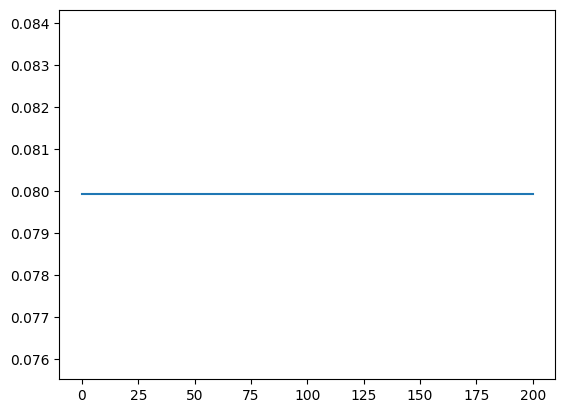

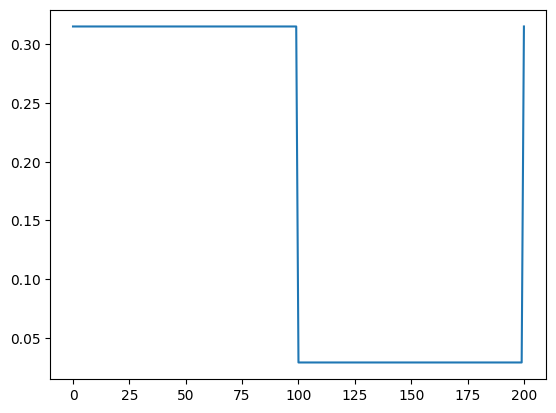

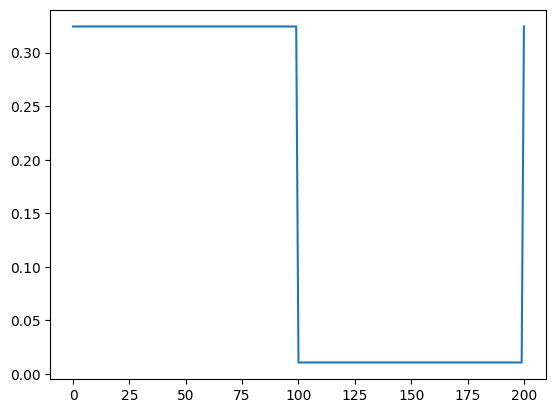

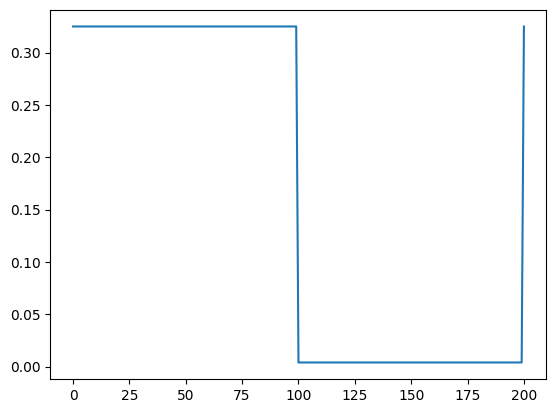

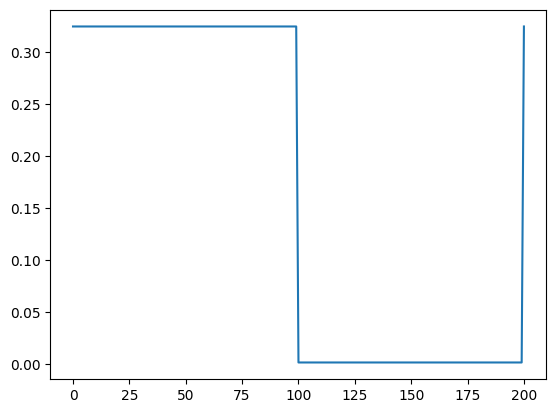

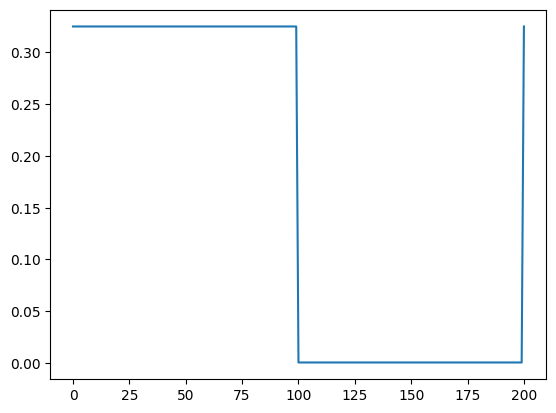

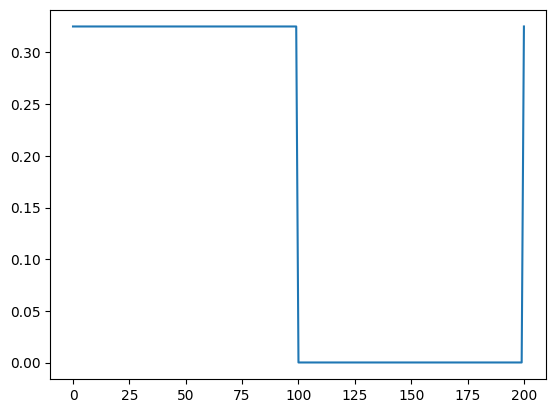

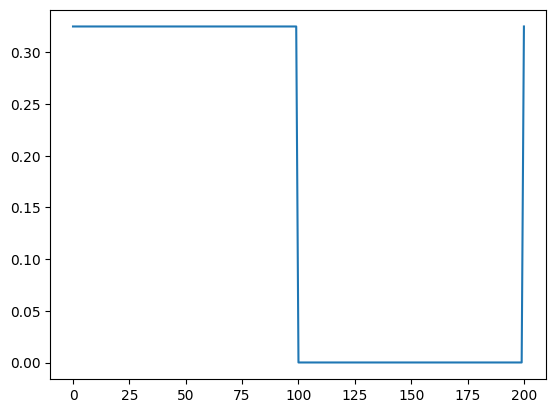

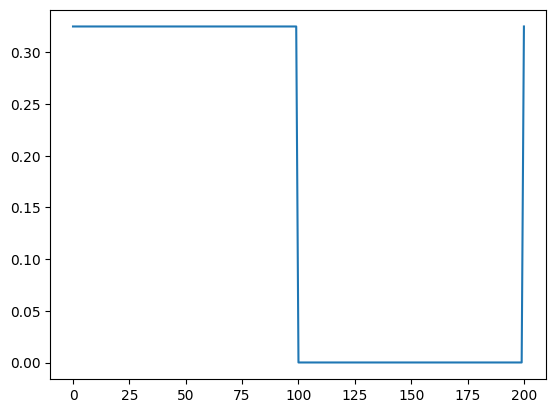

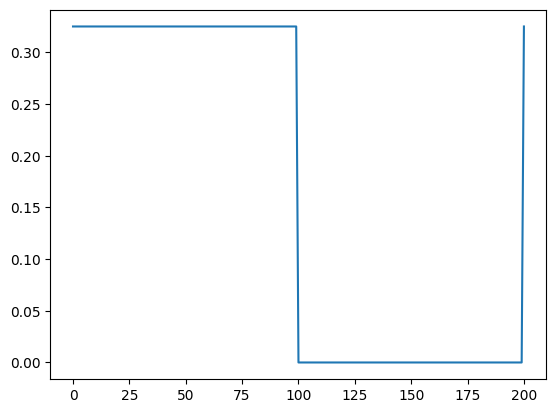

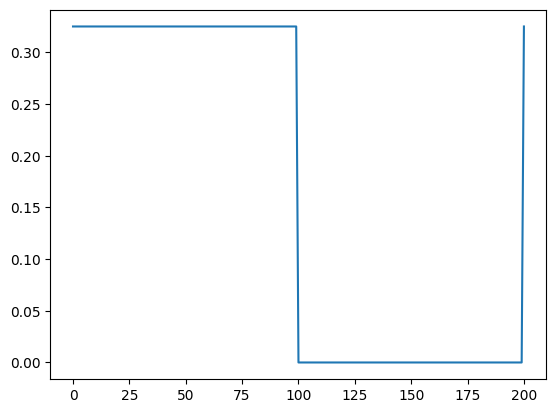

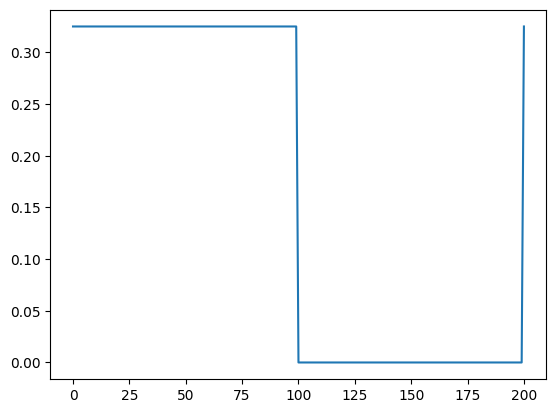

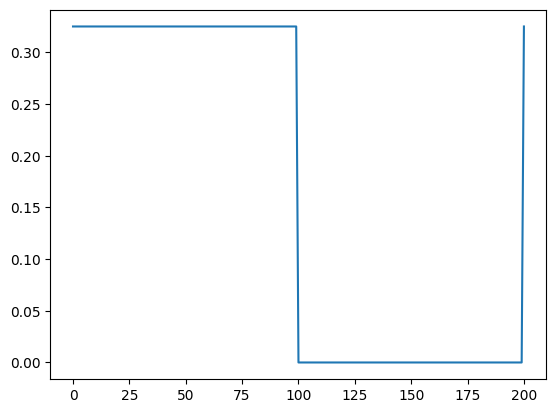

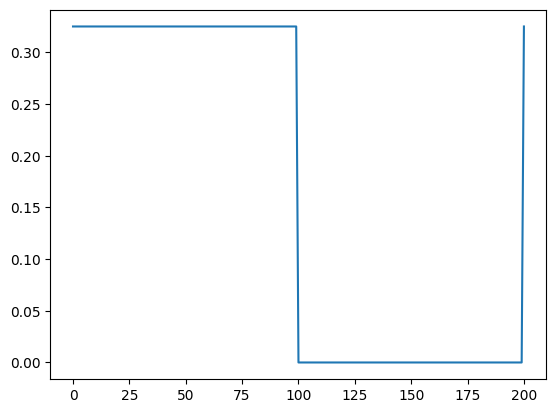

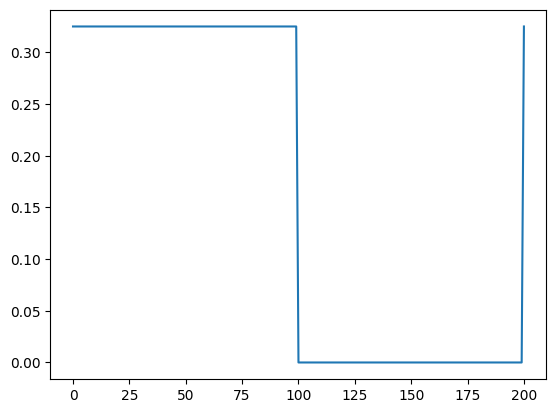

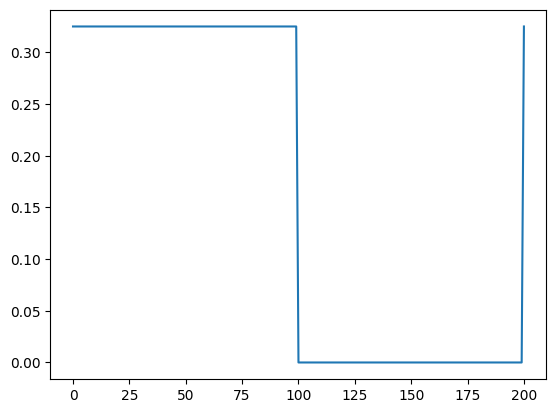

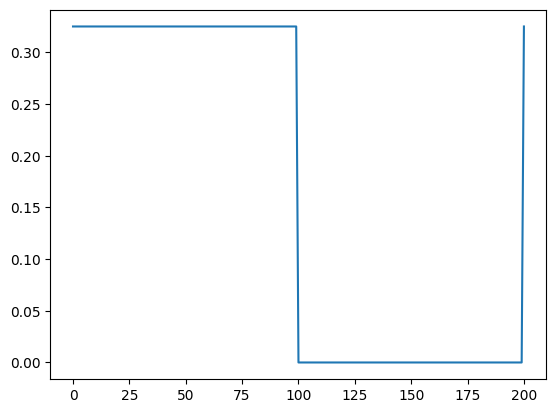

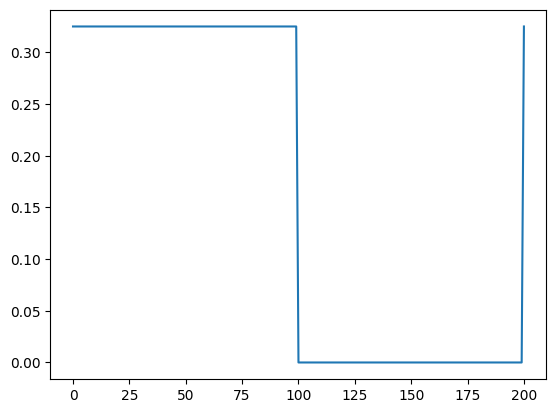

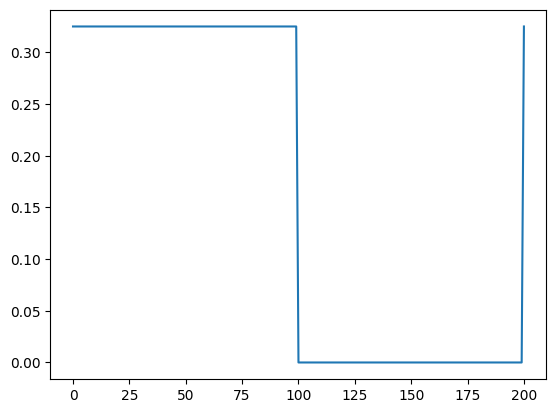

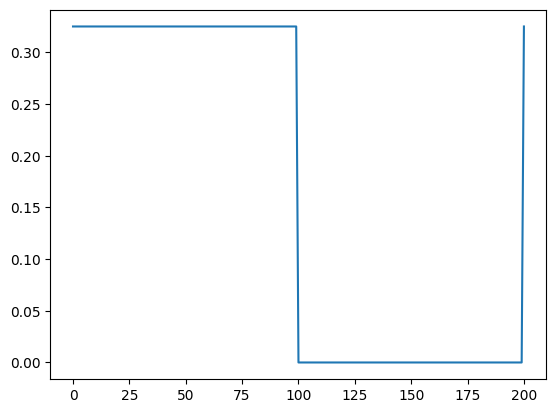

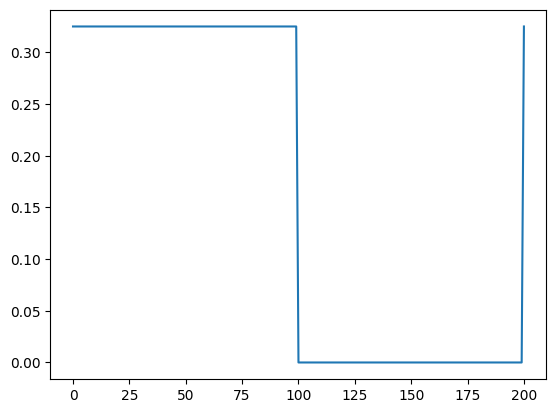

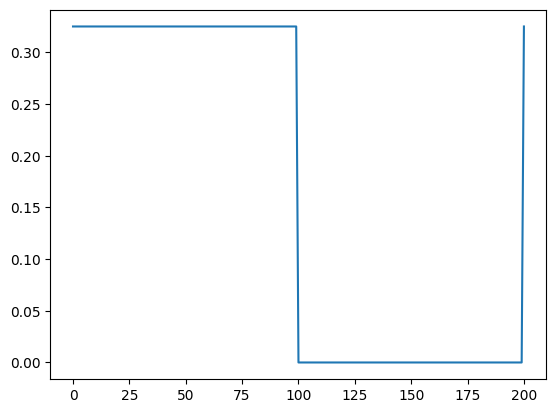

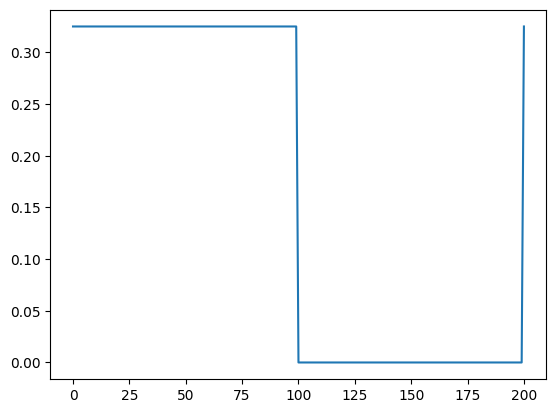

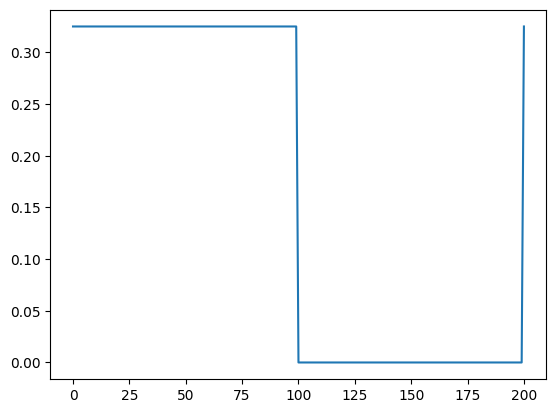

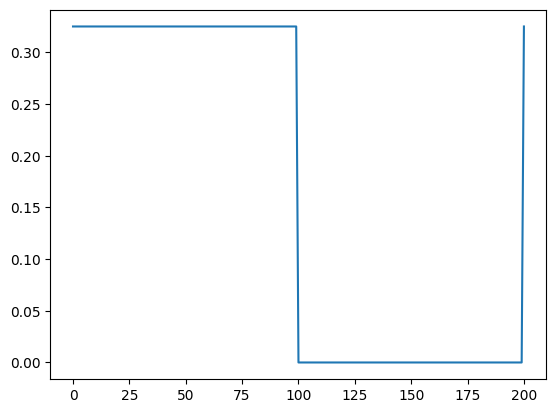

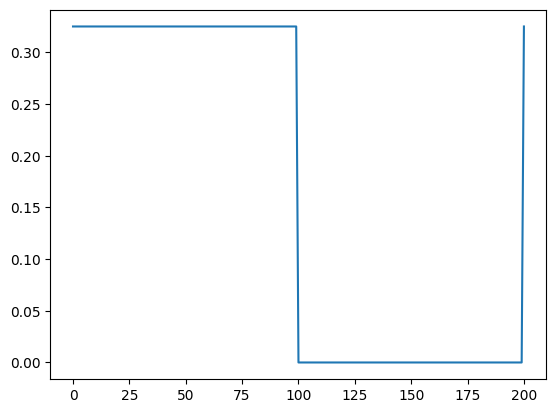

KeyboardInterrupt: 

In [41]:
# 1e-2: learns at same speed

grokker = Grokker(n_train_samples=100, n_test_samples=100, n_classes=100, rel_speed=1e-2)
train(grokker, n_steps=10_000, beta=0.1)